In [1]:
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import seaborn as sns

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

# Data set cleaned for Covid-19 modelling

the file COVED_small_flat_table has to be generated via the NOTEBOOK DATA PREPARATION

Goal of the exercise a dynamic dashboard of the last cell in the notebook, where one can select the fit for different countries

Fit of SIR model for Germany cases


In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv('../../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,Italy,US,Spain,Germany,India
0,2020-01-22,0,1,0,0,0
1,2020-01-23,0,1,0,0,0
2,2020-01-24,0,2,0,0,0
3,2020-01-25,0,2,0,0,0
4,2020-01-26,0,5,0,0,0
...,...,...,...,...,...,...
875,2022-06-15,17736696,85942237,12515127,27096571,43257730
876,2022-06-16,17773764,86058228,12515127,27124689,43270577
877,2022-06-17,17809934,86216418,12563399,27204953,43283793
878,2022-06-18,17844905,86230982,12563399,27204955,43296692


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Italy[35]
S0=N0-I0
R0=0

print('Number of infected person:', I0)
print('Number of suspetible person:', S0)
print('Number of recovered person:', R0)

Number of infected person: 453
Number of suspetible person: 999547
Number of recovered person: 0


In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: infection rate
        gamma: recovery rate
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


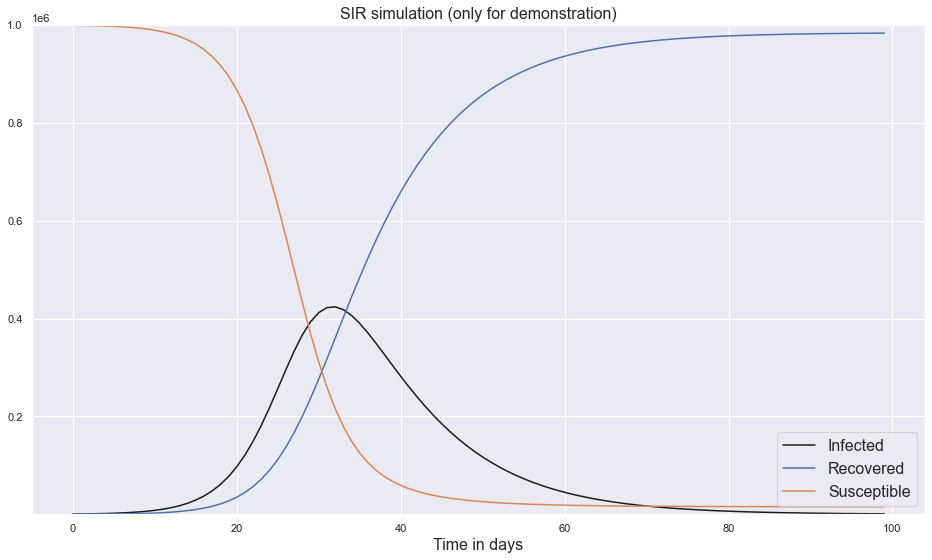

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='Infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='Recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='Susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('SIR simulation (only for demonstration)',size=16)
ax1.set_xlabel('Time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting data to a model

## step one: always start on simulative / constructive data

Goal is to fit a data model (SIR) model to obtain the parameters
beta and gamma

step one: always start on simulative / constructive data
step two: cross check if the innerlogic of your parameter fitting is correct

In [7]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: infection rate
        gamma: recovery rate
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [8]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [9]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [10]:
#ydata

In [11]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



<ipython-input-7-80ce3711d14a>:17: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-80ce3711d14a>:18: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-80ce3711d14a>:19: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Dell\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00075585 0.00058162]  start infect: 588.8179164000001
Optimal parameters: beta = 0.38093069223789616  and gamma =  0.09669917120921108


In [12]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

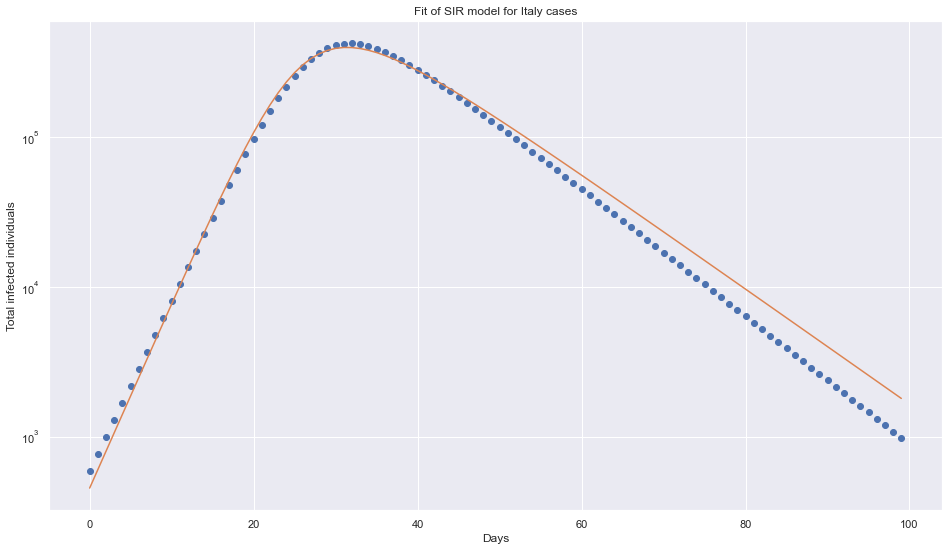

Optimal parameters: beta = 0.38093069223789616  and gamma =  0.09669917120921108
Basic Reproduction Number R0  3.939337715870833
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [13]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("Total infected individuals")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting the parameters of SIR model
the SIR model is assuming a very simplistic curve
however we can find situations (time windows) where the model might apply

In [14]:
## slice out some true data of a country

ydata = np.array(df_analyse.Italy[40:150])
t=np.arange(len(ydata))

In [15]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('Infected individuals:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

Infected individuals: 2036
cumulative sum of invected after period 238011
Number of days 110
N0 10000000


In [16]:

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

standard deviation errors :  [0.0060185  0.00574101]  start infect: 2036
Optimal parameters: beta = 0.3451379817977155  and gamma =  0.2659438674223654


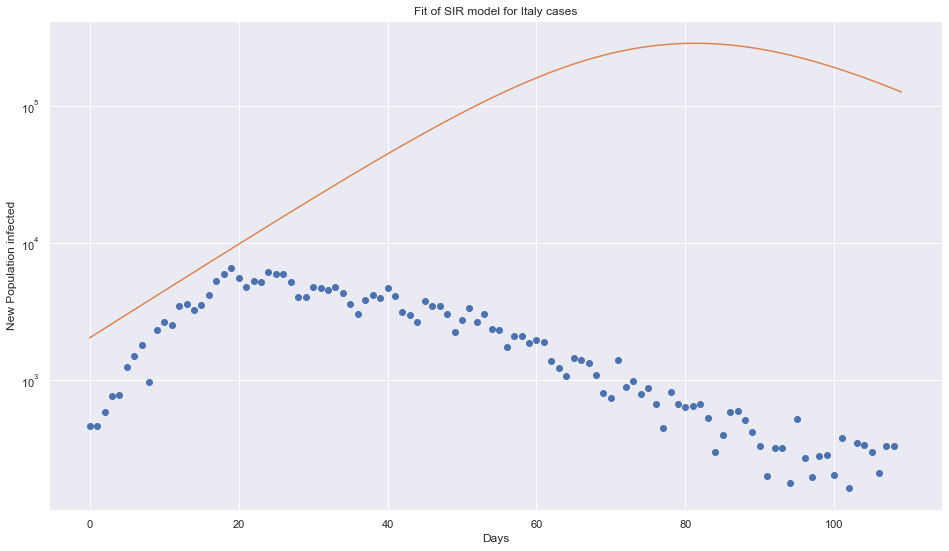

Optimal parameters: beta = 0.3451379817977155  and gamma =  0.2659438674223654
Basic Reproduction Number R0  1.2977850745081327
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [17]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

##  Dynamic Dashboard for SIR model

In [18]:
data_path = r"../../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
pd_raw = pd.read_csv(data_path)
pd_raw

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/10/22,6/11/22,6/12/22,6/13/22,6/14/22,6/15/22,6/16/22,6/17/22,6/18/22,6/19/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,180864,180864,180864,181120,181178,181236,181465,181534,181574,181666
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,276638,276690,276731,276731,276821,276821,276821,277141,277141,277409
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,265925,265925,265927,265937,265943,265952,265964,265968,265971,265975
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,43224,43224,43224,43224,43224,43449,43449,43449,43449,43449
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,99761,99761,99761,99761,99761,99761,99761,99761,99761,99761
5,NaN,Antarctica,-71.949900,23.347000,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
6,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,8479,8479,8492,8531,8537,8537,8537,8555,8581,8581
7,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,9276618,9276618,9276618,9276618,9313453,9313453,9313453,9313453,9313453,9341492
8,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,423006,423006,423006,423006,423044,423044,423044,423044,423044,423044
9,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,139894,140519,140519,141660,142629,143656,144597,145457,146264,147096


In [19]:
country_list=['US','Germany','Italy']
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T

df_analyse.to_csv('../../data/raw/data_SIR.csv',index=False)

In [20]:
N0=1000000 #max susceptible population as shown in the lecture taken random
beta=0.4   # infection spread dynamic
gamma=0.1  # recovery rate

df_data_=df_analyse[40:140]
t=np.arange(df_data_.shape[0])

R0=0

df_data = df_data_.drop(['Date'], axis=1).diff().fillna(0)
df_data.insert(0,'Date', df_data_['Date'])

for country in country_list:
    #ydata = np.array(df_data)
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

df_data = df_data.reset_index(drop=True)
df_data.to_csv('../../data/processed/SIR_fitted_curve.csv')

In [ ]:
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    # SIR Model Dashboard
    '''),

    dcc.Markdown('''
    ## Select Country
    '''),
    
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in country_list],
        value='Italy', # which are pre-selected
        multi=False),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])

def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Confirmed'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],
                           y=df_data[each][1:],
                           mode='line',
                           name=each))
        
        traces.append(dict(x=df_data['Date'],
                           y=df_data[each+'_fitted'][2:],
                           mode='lines+markers',
                           name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,
                xaxis={'title':'Time',
                       'tickangle':-45,
                       'nticks':20,
                       'tickfont':dict(size=14,color="#0c6887"),
                      },
                yaxis=my_yaxis
            )
    }

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    # Task 2: SIR Virus spread model implemented in Dynamic Dashboard 
    
    
    Select any country that needs to be visualize
    '''),


    dcc.Dropdown(
        id = 'country_drop_down',
        options=[ {'label': each,'value':each} for each in df_input_large['country'].unique()],
        value= 'France', 
        multi=False),

    dcc.Graph(figure = fig, id = 'SIR_graph')
    ])

#def SIR(countries):
#
#    SIR_modelling()


@app.callback(
    Output('SIR_graph', 'figure'),
    [Input('country_drop_down', 'value')])

def update_SIR_figure(country_drop_down):

    traces = []

    df_plot = df_input_large[df_input_large['country'] == country_drop_down]
    df_plot = df_plot[['state', 'country', 'confirmed','confirmed_filtered', 'date']].groupby(['country', 'date']).agg(np.sum).reset_index()
    df_plot.sort_values('date', ascending = True).head()
    df_plot = df_plot.confirmed[40:]

    t, fitted = SIR_modelling(df_plot)

    traces.append(dict (x = t,
                        y = fitted,
                        mode = 'markers',
                        opacity = 1.1,
                        name = 'SIR-model-curve')
                  )

    traces.append(dict (x = t,
                        y = df_plot,
                        mode = 'lines',
                        opacity = 0.7,
                        name = 'Original Data curve')
                  )

    return {
            'data': traces,
            'layout': dict (
                width=1200,
                height=700,
                title = 'SIR model fitting',

                xaxis= {'title':'Days',
                       'tickangle':-48,
                        'nticks':21,
                        'tickfont':dict(size=16,color="#7f7f7f"),
                      },

                yaxis={'title': "Infected population"}
        )
    }


if __name__ == '__main__':
    app.run_server(debug = True, use_reloader = False)